<a href="https://colab.research.google.com/github/nikogarro/Deep-Learning/blob/main/Malaria_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [6]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split =['train'])

In [9]:
def split(dataset, Train_Ratio, Val_Ratio, Test_Ratio):
    Dataset_size = len(dataset)

    train_dataset = dataset.take(int(Train_Ratio*Dataset_size))

    val_test_dataset = dataset.skip(int(Train_Ratio*Dataset_size))
    val_dataset = val_test_dataset.take(int(Val_Ratio*Dataset_size))

    test_dataset = val_test_dataset.skip(int(Val_Ratio*Dataset_size))

    return train_dataset, val_dataset, test_dataset

In [10]:
Train_Ratio = 0.9
Val_Ratio = 0.5
Test_Ratio = 0.5

In [11]:
train_dataset, val_dataset, test_dataset = split(dataset[0], Train_Ratio, Val_Ratio, Test_Ratio)

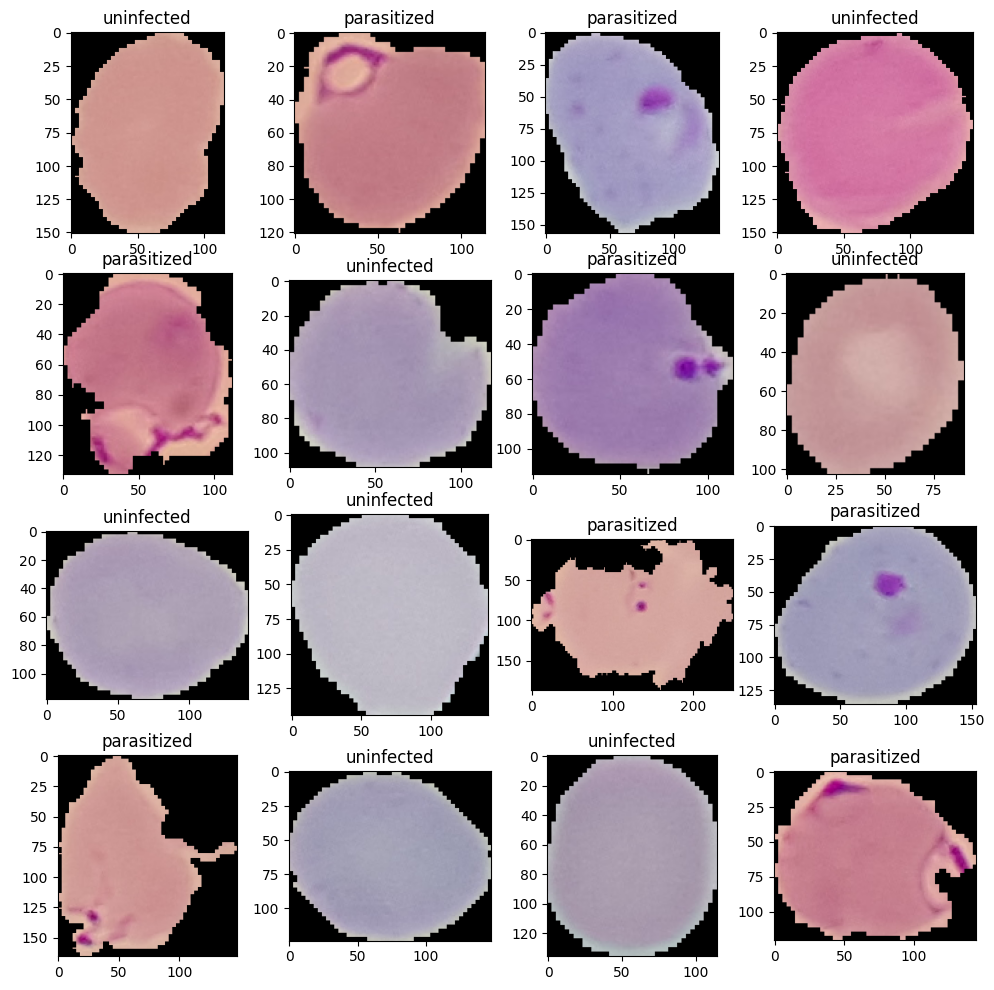

In [22]:
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))